In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
# import pytorch_lightning as pl

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', -1)

from our_datasets import PlantCLEF2022Supr, PlantCLEF2022_Dataset


C:\Users\maeot\AppData\Local\Temp/ipykernel_22464/4173136222.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [3]:
columns = ["classid", "image_path", "species", "genus", "family", "gbif_occurrence_id"]
df = pd.read_csv("./trusted/PlantCLEF2022_trusted_training_metadata.csv", sep=";", usecols=columns)

In [5]:
df['classid'].nunique(), df['species'].nunique(), df['gbif_occurrence_id'].nunique()

(80000, 80000, 1794964)

In [27]:
freqs = df['gbif_occurrence_id'].value_counts()

In [30]:
freqs['gbif_occurrence_id'] = freqs['gbif_occurrence_id'].str
freqs

KeyError: 'gbif_occurrence_id'

<AxesSubplot:>

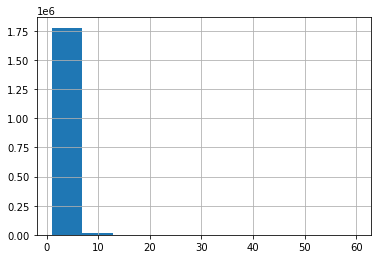

In [31]:
df['gbif_occurrence_id'].value_counts().hist()

<AxesSubplot:>

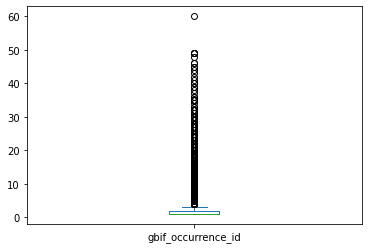

In [24]:
df['gbif_occurrence_id'].value_counts().plot.box()

In [ ]:
df.species.nunique(), df.genus.nunique(), df.family.nunique()

In [9]:
# df.sort_values(['family', 'genus', 'species'], ascending=True)
df.head(200)

,classid,image_path,species,genus,family
0,2683260,2683260/d0749fe4f8ade13dd9402b0f43bc29e8f28af27a.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
1,2683260,2683260/7549c8ddadd95d996e10aa76f8e39bedb059c637.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
2,2683260,2683260/8c6049ebdff482b901f32e0ac9e421c69bc652b4.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
3,2683260,2683260/b932fd8619c667a5b4f3c38596911937a2692b26.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
4,2683260,2683260/9f9dbdb0b9ce8bc3fb562f648af7717b5511b597.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
...,...,...,...,...,...
195,2683252,2683252/bee24d7289f9f73e60691619e8e93d345c817ec3.jpg,Cycas media R.Br.,Cycas,Cycadaceae
196,2683252,2683252/963b13a95820db21a90cb4bcd1080e0863140f76.jpg,Cycas media R.Br.,Cycas,Cycadaceae
197,2683252,2683252/5452fe43d0fbab6093682a2ec396b8f9cd2f7051.jpg,Cycas media R.Br.,Cycas,Cycadaceae
198,2683252,2683252/12a068fd2cdf17f27f4518b93e2b524081c0c175.jpg,Cycas media R.Br.,Cycas,Cycadaceae


In [7]:
# # dfo = df[df["classid"]]
# df.groupby(["classid"]).count().plot.bar()

(80000, 2)


<AxesSubplot:xlabel='genus'>

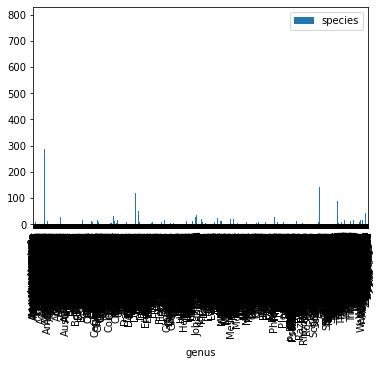

In [8]:
dfh = df[["genus", "species"]].drop_duplicates()
print(dfh.shape)
dfh.groupby(["genus"]).count().plot.bar()

In [9]:
dfh.groupby(["genus"]).count().max()

species    790
dtype: int64

(80000, 2)


<AxesSubplot:xlabel='family'>

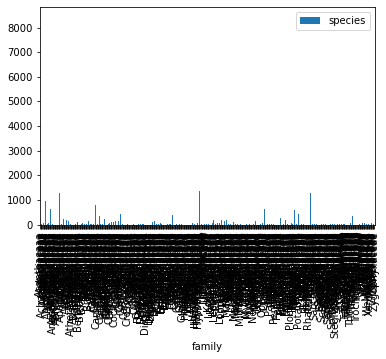

In [50]:
dff = df[["family", "species"]].drop_duplicates()
print(dff.shape)
dff.groupby(["family"]).count().plot.bar()

In [51]:
dff.groupby(["family"]).count().max()

species    8408
dtype: int64

In [16]:
dff[dff.family == 'Zamiaceae'].count()

family    9
genus     9
dtype: int64

(483, 8408)

In [67]:
dfi[dfi['id_s'] == 790]

,family,genus,species,id_g,id_s
437272,Cyperaceae,Carex,Carex zuluensis C.B.Clarke,1358,790


In [108]:
pd.set_option('display.max_rows', None)


def create_tree(col_f='family', col_g='genus', col_s='species', col_classid='classid'):
    cols_to_use = [col_f, col_g, col_s, col_classid]

    dfi = df[cols_to_use].drop_duplicates().copy()

    #inside genus
    dfi['id_g'] = (dfi[col_g] != dfi[col_g].shift(1)).cumsum()
    dfi['id_s'] = dfi.groupby([col_g]).cumcount()+1 #good

    #inside family
    # dfi['id_g']=(dfi['family'] != dfi['family'].shift(1)).cumsum()
    # dfi['id_s']=dfi.groupby(['family']).cumcount()+1 #good
    # print(dfi['id_g'].max(), dfi['id_s'].max())

    dfo = pd.merge(df,dfi,on=cols_to_use,how='inner')
    return dfo


dff = create_tree()
dff.head(10)




,classid,image_path,species,genus,family,id_g,id_s
0,2683260,2683260/d0749fe4f8ade13dd9402b0f43bc29e8f28af27a.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,1,1
1,2683260,2683260/7549c8ddadd95d996e10aa76f8e39bedb059c637.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,1,1
2,2683260,2683260/8c6049ebdff482b901f32e0ac9e421c69bc652b4.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,1,1
3,2683260,2683260/b932fd8619c667a5b4f3c38596911937a2692b26.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,1,1
4,2683260,2683260/9f9dbdb0b9ce8bc3fb562f648af7717b5511b597.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,1,1
5,2683214,2683214/f65f413a195eea01854df1108cc2fe38f79c3326.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,1,2
6,2683214,2683214/e4801e0358cfb55102d4a955ae9b6079f241a804.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,1,2
7,2683214,2683214/a1b333e597ae5392280f3794c3651f5fde842773.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,1,2
8,2683214,2683214/5a99b3752ec989355de60d83bca6ef8ea8cafa81.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,1,2
9,2683214,2683214/ef11ef5d9e79b1f8a5b725800a6c449214350d7b.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,1,2


In [95]:
# dfi.reset_index()
# dfi['id_g', 'id_s'].head()

In [97]:
dfo.head(200)

,classid,image_path,species_x,genus_x,family_x,family_y,genus_y,species_y,id_g,id_s
0,2683260,2683260/d0749fe4f8ade13dd9402b0f43bc29e8f28af27a.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas angulata R.Br.,1,1
1,2683260,2683260/7549c8ddadd95d996e10aa76f8e39bedb059c637.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas angulata R.Br.,1,1
2,2683260,2683260/8c6049ebdff482b901f32e0ac9e421c69bc652b4.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas angulata R.Br.,1,1
3,2683260,2683260/b932fd8619c667a5b4f3c38596911937a2692b26.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas angulata R.Br.,1,1
4,2683260,2683260/9f9dbdb0b9ce8bc3fb562f648af7717b5511b597.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas angulata R.Br.,1,1
5,2683214,2683214/f65f413a195eea01854df1108cc2fe38f79c3326.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas armstrongii Miq.,1,2
6,2683214,2683214/e4801e0358cfb55102d4a955ae9b6079f241a804.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas armstrongii Miq.,1,2
7,2683214,2683214/a1b333e597ae5392280f3794c3651f5fde842773.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas armstrongii Miq.,1,2
8,2683214,2683214/5a99b3752ec989355de60d83bca6ef8ea8cafa81.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas armstrongii Miq.,1,2
9,2683214,2683214/ef11ef5d9e79b1f8a5b725800a6c449214350d7b.jpg,Cycas armstrongii Miq.,Cycas,Cycadaceae,Cycadaceae,Cycas,Cycas armstrongii Miq.,1,2


In [23]:
!pip install transformers


In [24]:
from transformers import BertConfig, BertModel

# Download model and configuration from huggingface.co and cache.
model = BertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [17]:
import os

import hydra
import pandas as pd
import pytorch_lightning as pl
import torch
from omegaconf import DictConfig
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import PlatCLEFSimCLR, PlantCLEF2022Supr
from engines import SimCLREngine, SuprEngine
from models import ResNetSelfSupr, ResNetClassifier


def get_engine(cfg, loader, loader_val, model):
    engines = {"simclr": SimCLREngine, "supr": SuprEngine}
    return engines[cfg.engine.name](model=model, loader=loader, loader_val=loader_val, cfg=cfg)


def get_model(cfg, original_path, class_size):
    if cfg.model.name == "resnet":
        if cfg.engine.name == "supr":
            saved_model = ResNetSelfSupr(base_model=cfg.model.arch, out_dim=cfg.model.out_dim)
            _ = SimCLREngine.load_from_checkpoint(os.path.join(original_path, cfg.pretrained_point),
                                                  model=saved_model, loader=None, loader_val=None, cfg=cfg)
            return ResNetClassifier(saved_model, feature_dim=cfg.model.out_dim, class_dim=class_size)
        else:
            return ResNetSelfSupr(base_model=cfg.model.arch, out_dim=cfg.model.out_dim)


def get_dataset(original_path, cfg):
    columns = ["classid", "image_path", "species", "genus", "family"]
    df = pd.read_csv(os.path.join(original_path, cfg.dataset.csv), sep=";", usecols=columns)
    if cfg.dataset.name == "web":
        ds = PlatCLEFSimCLR(df, root=os.path.join(original_path, cfg.dataset.image_root),
                            label_col=cfg.dataset.label_col,
                            filename_col=cfg.dataset.filename_col,
                            size=cfg.resolution)
        return ds, ds, None
    if cfg.dataset.name == "trusted":
        transform = transforms.Compose([transforms.Resize([cfg.resolution, cfg.resolution]),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        ])
        ds = PlantCLEF2022Supr(df, root=os.path.join(original_path, cfg.dataset.image_root),
                               label_col=cfg.dataset.label_col, filename_col=cfg.dataset.filename_col,
                               transform=transform)
        dst, dsv = ds.split(train_perc=cfg.dataset.train_perc)
        return ds, dst, dsv


# @hydra.main(config_path="config", config_name="simclr.yaml")
@hydra.main(config_path="config", config_name="supr.yaml")
def run(cfg: DictConfig):
    original_path = hydra.utils.get_original_cwd()
    ds, dst, dsv = get_dataset(original_path=original_path, cfg=cfg)
    loader = torch.utils.data.DataLoader(dst, batch_size=cfg.dataset.batch_size, shuffle=True, drop_last=True,
                                         num_workers=cfg.num_workers, persistent_workers=True)
    loader_val = torch.utils.data.DataLoader(dst, batch_size=cfg.dataset.batch_size, shuffle=True, drop_last=True,
                                             num_workers=cfg.num_workers, persistent_workers=True) if dsv else None

    print(loader)
    print(loader_val)
    model = get_model(cfg=cfg, original_path=original_path, class_size=ds.class_size)
    engine = get_engine(cfg=cfg, loader=loader, loader_val=loader_val, model=model)

    from pytorch_lightning.callbacks import ModelCheckpoint

    checkpoint_callback = ModelCheckpoint(
        monitor="train_loss",
        dirpath=os.path.join(original_path, cfg.checkpoints),
        save_top_k=2,
        mode="min",
        filename=f"{cfg.engine.name}-" + "{epoch}-{train_loss:.2f}-{train_acc_top1:.2f}",
        save_on_train_epoch_end=True,
        every_n_train_steps=int((len(ds) / cfg.dataset.batch_size) * cfg.time_per_epoch)
    )

    tb_logger = pl_loggers.TensorBoardLogger(os.path.join(original_path, "logs/"))
    wandb_logger = WandbLogger()

    callbacks = [checkpoint_callback]
    val_loaders = []
    if dsv:
        callbacks.append(EarlyStopping(monitor="val_loss"))
        val_loaders.append(loader_val)

    trainer = pl.Trainer(gpus=1, num_nodes=1, precision=cfg.precision,
                             callbacks=callbacks, logger=[tb_logger])
    if cfg.last_checkpoint:
        trainer.fit(engine, train_dataloader=loader, val_dataloaders=val_loaders, ckpt_path=os.path.join(original_path, cfg.last_checkpoint))
    else:
        trainer.fit(engine, train_dataloader=loader, val_dataloaders=val_loaders)


In [18]:
df_trusted.head()

,classid,image_path,species,genus,family
0,2683260,2683260/d0749fe4f8ade13dd9402b0f43bc29e8f28af27a.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
1,2683260,2683260/7549c8ddadd95d996e10aa76f8e39bedb059c637.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
2,2683260,2683260/8c6049ebdff482b901f32e0ac9e421c69bc652b4.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
3,2683260,2683260/b932fd8619c667a5b4f3c38596911937a2692b26.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae
4,2683260,2683260/9f9dbdb0b9ce8bc3fb562f648af7717b5511b597.jpg,Cycas angulata R.Br.,Cycas,Cycadaceae


In [19]:
df_trusted.shape

(2886761, 5)

In [20]:
df_trusted.classid.nunique(),  df_trusted.species.nunique(), df_trusted.genus.nunique(), df_trusted.family.nunique()

(80000, 80000, 9603, 483)


# Supervised
    

## Data preparation

In [21]:
args = {}
args['description'] = 'PyTorch Supr'
args['epochs'] = 10
args['batch_size'] = 56
args['lr'] = 0.0003
args['weight_decay'] = 1e-4
args['out_dim'] = 128 
args['log_every_n_steps'] = 10
args['temperature'] = 0.07
args['n_views'] = 2
args['arch'] = 'resnet50'
args['seed'] = None
args['fp16_precision'] = True
args['checkpoints'] = "supr_checkpoints"
args['num_workers'] = 4
args['chekpoint_point'] = "selfsupr_checkpoints/selfsupr-epoch=25-selfsupr_train_loss=0.64-selfsupr_train_acc_top1=78.12.ckpt"

In [22]:
transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                               ])
ds = PlantCLEF2022Supr(df_trusted, root="C:\\Users\\maeot\\Documents\\code\\biomachina\\trusted\\images\\", 
                           label_col="species", filename_col="image_path", transform=transform)
ds

Dataset PlantCLEF2022Supr
    Number of datapoints: 62207
    Root Location: C:\Users\maeot\Documents\code\biomachina\trusted\images\
    Transforms (if any): Compose(
                             Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=None)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )

In [23]:
ds.class_size

2109

### Visualize sample

In [24]:
loader = torch.utils.data.DataLoader(ds, batch_size=args['batch_size'], shuffle=True, drop_last=True, num_workers=args['num_workers'], persistent_workers=True)
dataiter = iter(loader)
images, labels = dataiter.next() #images = list with 2 tensors of (B, C, H, W)
images.shape, labels

(torch.Size([56, 3, 224, 224]),
 tensor([1762, 1039,  429, 2050, 2070, 2018, 1401,   36,  128, 1084, 1895,  629,
         2031,  729,  710,  876,  339,  165, 2074,  941,  182,  488,  947, 1716,
          867,  179,   11, 1832, 1753,  333,  426, 1397,  796,  504, 1469, 1133,
          340, 1566, 1966,  988,  421,  760,  740,  567,  570, 1979,  484,   33,
         1644, 1514,  939,  141,  959,  628, 1583,  548]))

In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


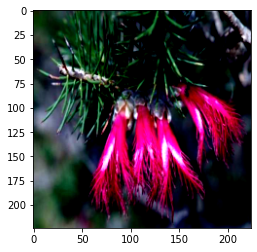

In [26]:
imshow(images[0])

## Training

In [27]:
from engines import SuprEngine, SimCLREngine
from models import ResNetSelfSupr, ResNetClassifier

selfsupr_model = ResNetSelfSupr(base_model=args['arch'], out_dim=args['out_dim'])
# selfsupr_engine = SimCLREngine.load_from_checkpoint(args['chekpoint_point'], model=selfsupr_model, loader=None, args=args)

model = ResNetClassifier(selfsupr_model, feature_dim=args['out_dim'], class_dim=ds.class_size)
engine = SuprEngine(model=model, loader=loader, args=args)


In [28]:
from pytorch_lightning.callbacks import ModelCheckpoint

SAVE_X_TIMES_PER_EPOCH = 0.1

checkpoint_callback = ModelCheckpoint(
        monitor="supr_train_loss", 
        dirpath=args["checkpoints"], 
        save_top_k=2, 
        mode="min",
        filename="supr-{epoch}-{supr_train_loss:.2f}-{supr_train_acc_top1:.2f}",
        save_on_train_epoch_end = True,
        every_n_train_steps = int((len(ds) / args['batch_size']) * SAVE_X_TIMES_PER_EPOCH)
)

In [29]:
trainer = pl.Trainer(gpus=1, num_nodes=1, 
                     precision=16, limit_train_batches=0.5, 
                     callbacks=[checkpoint_callback])
trainer.fit(engine, loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNetClassifier | 28.2 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
28.2 M    Trainable params
0         Non-trainable params
28.2 M    Total params
56.477    Total estimated model params size (MB)
C:\Users\maeot\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\maeot\Documents\code\biomachina\supr_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Training: 0it [00:00, ?it/s]

C:\Users\maeot\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
